In [1]:
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
import numpy as np
from torchvision import transforms
import math
from torch.utils.data import Dataset

In [2]:
data_path = r"D:\dataset\data_residuos"

In [3]:
# transformaciones
transform = transforms.Compose([
    transforms.Resize((28, 28)),  
    transforms.ToTensor(),
    transforms.Normalize( mean=[0.485, 0.456, 0.406],  std=[0.229, 0.224, 0.225])
])

In [4]:
# dataset
class ResiduoDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None, patch_size=(7, 7)):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        self.patch_size = patch_size

    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.file_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        
        # patches
        c, h, w = img.shape
        patch_h, patch_w = self.patch_size
        
        patches = img.unfold(1, patch_h, patch_h).unfold(2, patch_w, patch_w)
        patches = patches.contiguous().view(c, -1, patch_h * patch_w)
        patches = patches.permute(1, 0, 2)
        patches = patches.reshape(patches.size(0), -1)
        
        return patches, self.labels[idx]

In [5]:
class ResiduoDataModule(pl.LightningDataModule):
    def __init__(self, data_path, batch_size=64, patch_size=(7, 7), max_samples=5000):
        super().__init__()
        self.data_path = data_path
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.max_samples = max_samples  
        self.transform = transform
    
    def setup(self, stage=None):
        self.file_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(self.data_path))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        
        for class_name in self.classes:
            class_path = os.path.join(self.data_path, class_name)
            if os.path.isdir(class_path):
                img_files = [f for f in os.listdir(class_path) 
                           if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                
                img_files = img_files[:self.max_samples]
                
                for img_name in img_files:
                    img_path = os.path.join(class_path, img_name)
                    self.file_paths.append(img_path)
                    self.labels.append(self.class_to_idx[class_name])
        
        # dividir 80/20
        total_size = len(self.file_paths)
        indices = list(range(total_size))
        random.shuffle(indices)
        
        train_size = int(0.8 * total_size)
        train_indices = indices[:train_size]
        val_indices = indices[train_size:]
        
        train_files = [self.file_paths[i] for i in train_indices]
        train_labels = [self.labels[i] for i in train_indices]
        val_files = [self.file_paths[i] for i in val_indices]
        val_labels = [self.labels[i] for i in val_indices]
        
        self.train_ds = ResiduoDataset(train_files, train_labels, self.transform, self.patch_size)
        self.val_ds = ResiduoDataset(val_files, val_labels, self.transform, self.patch_size)
    
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size)

In [6]:
# componentes del transformer
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.n_heads = n_heads
        
        self.key = torch.nn.Linear(n_embd, n_embd * n_heads)
        self.query = torch.nn.Linear(n_embd, n_embd * n_heads)
        self.value = torch.nn.Linear(n_embd, n_embd * n_heads)
        self.proj = torch.nn.Linear(n_embd * n_heads, n_embd)
    
    def forward(self, x):
        B, L, F = x.size()
        
        k = self.key(x).view(B, L, F, self.n_heads).transpose(1, 3)
        q = self.query(x).view(B, L, F, self.n_heads).transpose(1, 3)
        v = self.value(x).view(B, L, F, self.n_heads).transpose(1, 3)
        
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = torch.nn.functional.softmax(att, dim=-1)
        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, L, F * self.n_heads)
        
        return self.proj(y)

class TransformerBlock(torch.nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.ln1 = torch.nn.LayerNorm(n_embd)
        self.ln2 = torch.nn.LayerNorm(n_embd)
        self.attn = MultiHeadAttention(n_embd, n_heads)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(n_embd, 4 * n_embd),
            torch.nn.ReLU(),
            torch.nn.Linear(4 * n_embd, n_embd),
        )
    
    def forward(self, x):
        x = self.ln1(x + self.attn(x))
        x = self.ln2(x + self.mlp(x))
        return x

In [7]:
# modelo transformer
class Transformer(pl.LightningModule):
    def __init__(self, n_input=3*7*7, n_embd=128, seq_len=16, n_heads=4, n_layers=3, num_classes=6):
        super().__init__()
        self.pos_emb = torch.nn.Parameter(torch.zeros(1, seq_len, n_embd))
        self.inp_emb = torch.nn.Linear(n_input, n_embd)
        self.transformer = torch.nn.Sequential(
            *[TransformerBlock(n_embd, n_heads) for _ in range(n_layers)]
        )
        self.fc = torch.nn.Linear(n_embd * seq_len, num_classes)
        
    def forward(self, x):
        e = self.inp_emb(x) + self.pos_emb
        x = self.transformer(e)
        y = self.fc(x.view(x.size(0), -1))
        return y
    
    def predict(self, x):
        with torch.no_grad():
            y_hat = self(x)
            return torch.argmax(y_hat, axis=1)
    
    def compute_loss_and_acc(self, batch):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
        return loss, acc
    
    def training_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0003)
        return optimizer

In [8]:
# configuracion
dm = ResiduoDataModule(data_path, batch_size=64, max_samples=5000)
dm.setup()

num_classes = len(dm.classes)

# modelo
model = Transformer( n_input=3*7*7, n_embd=64, seq_len=16, n_heads=2, n_layers=1, num_classes=num_classes)

In [13]:
# train
trainer = pl.Trainer( max_epochs=11, accelerator='gpu', devices=1 if torch.cuda.is_available() else None, logger=None, enable_checkpointing=False)

trainer.fit(model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params | Mode 
----------------------------------------------------
0 | inp_emb      | Linear     | 9.5 K  | train
1 | transformer  | Sequential | 66.6 K | train
2 | fc           | Linear     | 5.1 K  | train
  | other params | n/a        | 1.0 K  | n/a  
----------------------------------------------------
82.2 K    Trainable params
0         Non-trainable params
82.2 K    Total params
0.329     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Epoch 10: 100%|██████████| 313/313 [00:52<00:00,  5.96it/s, v_num=3, train_loss=0.0572, train_acc=1.000, val_loss=0.153, val_acc=0.949]

`Trainer.fit` stopped: `max_epochs=11` reached.


Epoch 10: 100%|██████████| 313/313 [00:52<00:00,  5.96it/s, v_num=3, train_loss=0.0572, train_acc=1.000, val_loss=0.153, val_acc=0.949]


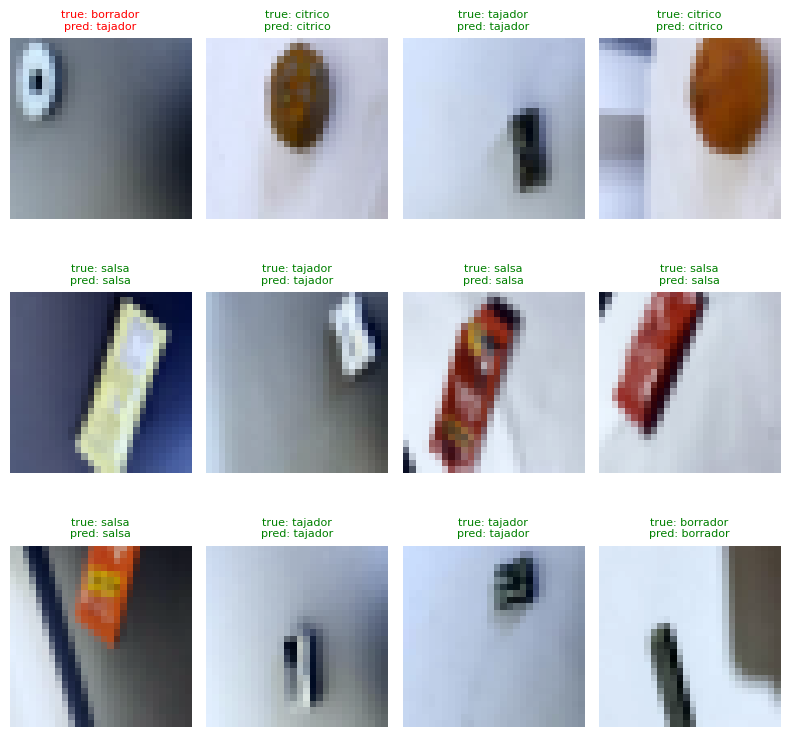

In [14]:
# evaluacion

# batch validacion
val_loader = dm.val_dataloader()
imgs, labels = next(iter(val_loader))
preds = model.predict(imgs)

# resultados
r, c = 3, 4
fig = plt.figure(figsize=(8, 8))

for i in range(min(r * c, len(imgs))):
    ax = plt.subplot(r, c, i + 1)
    
    # reconstruir imagen desde parches
    patches = imgs[i].view(16, 3, 7, 7)
    patch_grid = torch.zeros(3, 28, 28)
    
    for j in range(4):
        for k in range(4):
            patch_idx = j * 4 + k
            patch_grid[:, j*7:(j+1)*7, k*7:(k+1)*7] = patches[patch_idx].view(3, 7, 7)
    
    # desnormalizar 
    img_display = patch_grid.permute(1, 2, 0).numpy()
    img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
    
    ax.imshow(img_display)
    ax.axis('off')
    
    true_label = dm.classes[labels[i].item()]
    pred_label = dm.classes[preds[i].item()]
    
    color = "green" if labels[i] == preds[i] else "red"
    ax.set_title(f'true: {true_label}\npred: {pred_label}', 
                color=color, fontsize=8)

plt.tight_layout()
plt.show()